# Simple CNN for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
# from sklearn import preprocessing
import sys

sys.path.append("/home/rgadea/lmfit-py/")
sys.path.append("/home/rgadea/experimentos/viherbos/")

print(sys.path)
import json 

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['/home/rgadea/anaconda3/envs/tensorflow3/lib/python36.zip', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/lib-dynload', '', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/extensions', '/volumedisk0/home/rgadea/.ipython', '/home/rgadea/lmfit-py/', '/home/rgadea/experimentos/viherbos/']


Using TensorFlow backend.
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf
print(tf.__version__)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

1.13.1


## Vamos introducir los datos de petalo preprocesados en pyhton


In [3]:
# import scipy.io as sio
# import Event_Handle_red as  eh
# # import hdf5storage
# # datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total_2_distancias_red.mat')
# # conjunto_datos= datos_matlab.get('photodefbox2_todo_fil5')

# # npzfile = np.load('../conjuntos_datos_reconstruidos/fil5_pith7mm_rad165mm_scaled2_sig_sig_1200.npz')
# # npzfile.files
# path = "/home/rgadea/experimentos/viherbos/"
# data_file = "MOVIE_DATA_batch1.h5"
# json_file = "CUBE.json"
# def cart2pol(x, y,z):
#     rho = np.sqrt(x**2 + y**2)
#     phi = np.arctan2(y, x)
#     return(rho, phi,z)


# pepito=eh.Event_Handler(path, data_file, json_file)
# prueba=pepito(7)
# veamos=prueba['TRUE1']
# polares=cart2pol(veamos[0], veamos[1], veamos[2])
# print(np.asarray(polares))

# idea=pepito.DATA_A.shape #obtengo el numero de muestras

# entradas_sensorsA1=np.zeros([idea[0],20,175])
# entradas_sensorsB1=np.zeros([idea[0],20,175])
# coordenadas1=np.zeros([idea[0],3])
# entradas_sensorsA2=np.zeros([idea[0],20,175])
# entradas_sensorsB2=np.zeros([idea[0],20,175])
# coordenadas2=np.zeros([idea[0],3])
# for i in range(idea[0]):
#     DATA=pepito(i)
#     entradas_sensorsA1[i]=DATA['DATA_A1'];
#     entradas_sensorsB1[i]=DATA['DATA_B1'];    
#     veamos=DATA['TRUE1']
#     polares=cart2pol(veamos[0], veamos[1], veamos[2])
#     coordenadas1[i]=np.asarray(polares)
#     entradas_sensorsA2[i]=DATA['DATA_A2'];
#     entradas_sensorsB2[i]=DATA['DATA_B2'];    
#     veamos=DATA['TRUE2']
#     polares=cart2pol(veamos[0], veamos[1], veamos[2])
#     coordenadas2[i]=np.asarray(polares)

# np.savez('../conjuntos_datos_nuevos_2020/9_12_2019', entradas_sensorsA1,entradas_sensorsB1, coordenadas1,entradas_sensorsA2,entradas_sensorsB2, coordenadas2 )



## Network parameters:

In [4]:
npzfile = np.load('../conjuntos_datos_nuevos_2020/11_12_2019_filt.npz')
npzfile.files

conjunto_datos_entradasA=npzfile['arr_0']
conjunto_datos_entradasB=npzfile['arr_1']
conjunto_datos_salidas=npzfile['arr_2']


batch_size = 250
nb_classes = 10
nb_epoch = 1000

# input image dimensions
img_rows, img_cols = 20, 33
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

## Prepare data into training and test set.

In [5]:
muestras=conjunto_datos_entradasA.shape[0]
# veamos=idea.reshape(idea.shape[0],175, 20)


veamos2=np.zeros([muestras,20,175])
veamos2_3=np.zeros([muestras,20,525])
sector2A=np.zeros([muestras,20,img_cols])
sector2B=np.zeros([muestras,20,img_cols])
veamos3=np.zeros([muestras,175])
# for i in range(idea.shape[0]):
for i in range(muestras):
    veamos2[i]=conjunto_datos_entradasA[i]
    veamos3[i]=np.sum(veamos2[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    veamos2_3[i]=np.concatenate((veamos2[i],veamos2[i],veamos2[i]),axis=1) 
    indice_inferior=int(indice-((img_cols-1)/2)+175)
    indice_superior=int(indice+((img_cols+1)/2)+175)
    sector2A[i]=veamos2_3[i,:,indice_inferior:indice_superior]
for i in range(muestras):
    veamos2[i]=conjunto_datos_entradasB[i]
    veamos3[i]=np.sum(veamos2[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    veamos2_3[i]=np.concatenate((veamos2[i],veamos2[i],veamos2[i]),axis=1) 
    indice_inferior=int(indice-((img_cols-1)/2)+175)
    indice_superior=int(indice+((img_cols+1)/2)+175)
    sector2B[i]=veamos2_3[i,:,indice_inferior:indice_superior]    

print('sector A shape:', sector2A.shape)
conjunto_datos_nuevoA=sector2A.reshape(sector2A.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo A:', conjunto_datos_nuevoA.shape)

print('sector B shape:', sector2B.shape)
conjunto_datos_nuevoB=sector2B.reshape(sector2B.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo B:', conjunto_datos_nuevoB.shape)

sector A shape: (15690, 20, 33)
conjunto_datos_nuevo A: (15690, 660)
sector B shape: (15690, 20, 33)
conjunto_datos_nuevo B: (15690, 660)


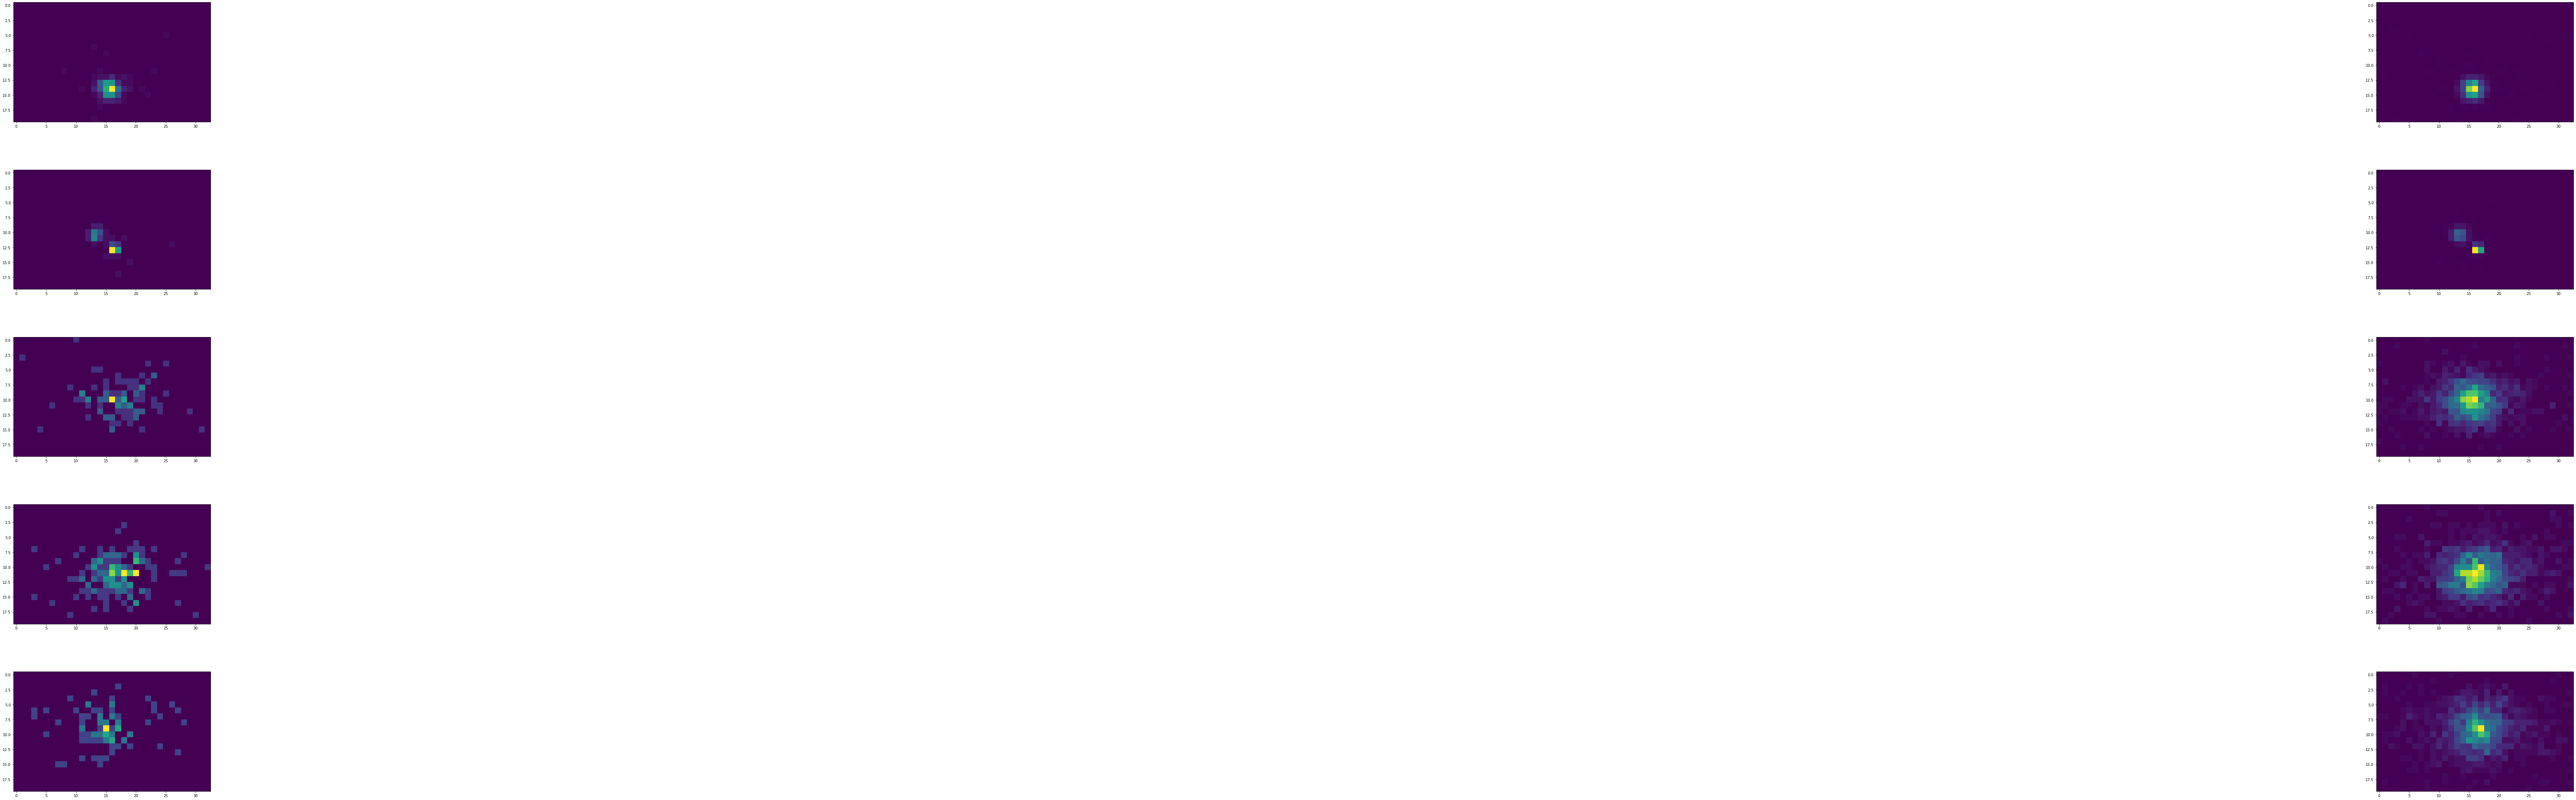

In [6]:
n = 5  # how many digits we will display

fig = plt.figure(figsize=(200, 40))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n):
    # display original
    ideas=np.random.randint(1,muestras)
    ax = plt.subplot(n, 2, (i)*2+1)
    plt.imshow(sector2A[ideas], cmap='viridis')
    plt.viridis()

    # display reconstruction
    ax = plt.subplot(n, 2, (i)*2+2)
    plt.imshow(sector2B[ideas], cmap='viridis')
    plt.viridis()

plt.show()

# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


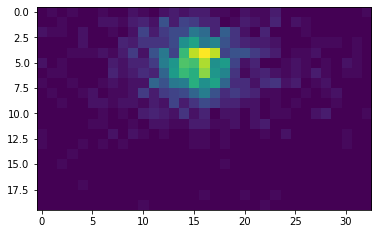

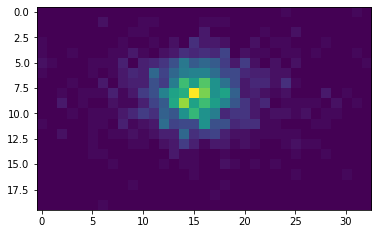

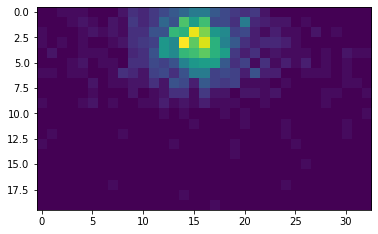

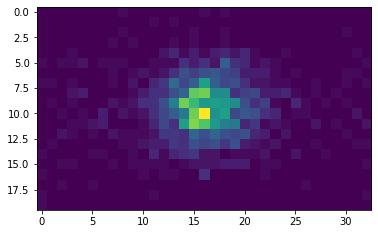

In [7]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,sector2B.shape[0])
    plt.imshow(sector2B[idea], cmap='viridis')
    plt.show()

In [8]:
numero_muestras=muestras
tr_size=60
val_size=20
test_size=100-val_size-tr_size
conjunto_datos_nuevo2=np.concatenate((conjunto_datos_salidas,conjunto_datos_nuevoB, conjunto_datos_nuevoA), axis=1)

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


XY_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,:]


XY_test_bin0=XY_test[np.where((XY_test[:,0]>=164.9999) * (XY_test[:,0]<171.000))]
XY_test_bin1=XY_test[np.where((XY_test[:,0]>=171.000) * (XY_test[:,0]<177.000))]
XY_test_bin2=XY_test[np.where((XY_test[:,0]>=177.000) * (XY_test[:,0]<183.0000))]
XY_test_bin3=XY_test[np.where((XY_test[:,0]>=183.000) * (XY_test[:,0]<189.0000))]
XY_test_bin4=XY_test[np.where((XY_test[:,0]>=189.0000))]

X_train=conjunto_datos_nuevo2[:tamanyo_tr,3:]
X_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,3:]
X_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,3:]

X_test_bin0=XY_test_bin0[:,3:]
Y_test_bin0=XY_test_bin0[:,0]
print(X_test_bin0.shape)
X_test_bin1=XY_test_bin1[:,3:]
Y_test_bin1=XY_test_bin1[:,0]
print(X_test_bin1.shape)
X_test_bin2=XY_test_bin2[:,3:]
Y_test_bin2=XY_test_bin2[:,0]
print(X_test_bin2.shape)
X_test_bin3=XY_test_bin3[:,3:]
Y_test_bin3=XY_test_bin3[:,0]
print(X_test_bin3.shape)
X_test_bin4=XY_test_bin4[:,3:]
Y_test_bin4=XY_test_bin4[:,0]
print(X_test_bin4.shape)



Y_train=conjunto_datos_nuevo2[:tamanyo_tr,0] #elijo la coordenada radius
Y_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,0] #elijo la corrdenada radius
Y_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,0] #elijo la corrdenada radius

9414
3138
3138
(971, 1320)
(799, 1320)
(612, 1320)
(461, 1320)
(295, 1320)


In [9]:


X_train = X_train.reshape(X_train.shape[0],2, img_rows, img_cols)
X_val = X_val.reshape(X_val.shape[0], 2, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 2,img_rows, img_cols)

X_test_bin0 = X_test_bin0.reshape(X_test_bin0.shape[0], 2, img_rows, img_cols)
X_test_bin1 = X_test_bin1.reshape(X_test_bin1.shape[0], 2, img_rows, img_cols)
X_test_bin2 = X_test_bin2.reshape(X_test_bin2.shape[0], 2, img_rows, img_cols)
X_test_bin3 = X_test_bin3.reshape(X_test_bin3.shape[0], 2, img_rows, img_cols)
X_test_bin4 = X_test_bin4.reshape(X_test_bin4.shape[0], 2, img_rows, img_cols)

input_shape = (2, img_rows, img_cols)
#input_shape=input_shape.astype('int32')

In [10]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (9414, 2, 20, 33)
9414 train samples
3138 validation samples
3138 test samples


Display 20 random training images using image

In [11]:
# # convert class vectors to binary class matrices
# #Y_train = np_utils.to_categorical(y_train, nb_classes)
# #Y_test = np_utils.to_categorical(y_test, nb_classes)
# for i in range(1,5):
#     idea=np.random.randint(1,X_train.shape[0])
#     plt.imshow(np.reshape(X_train[idea], [img_rows, img_cols]), cmap='viridis')
#     plt.show()

## Build the CNN. 

In [12]:
model = Sequential()

model.add(Conv2D(8, kernel_size=kernel_size,
                        padding='same',
                        data_format='channels_first',
                        input_shape=(2,img_rows,img_cols)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(16, kernel_size, padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(32, kernel_size, padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size, padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128, kernel_size, padding='same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))

experimento="CNN_kernel_{}x{}_con_batchnormalization_sector_{}x{}x{}".format(kernel_size[0],kernel_size[1],img_rows,img_cols,2)
algoritmo='Nadam'

tensorboard=TensorBoard(log_dir="../logs/defs/{}{}{}".format(experimento,algoritmo,datetime.now()))

model.compile(loss='mean_squared_error',
              optimizer=algoritmo)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Show a summary of the model parameters. 

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 8, 20, 33)         152       
_________________________________________________________________
activation_1 (Activation)    (None, 8, 20, 33)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 10, 33)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 10, 16)         4768      
_________________________________________________________________
activation_2 (Activation)    (None, 4, 10, 16)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 5, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 5, 32)          4640      
__________

And now train the model and evaluate on the test set. 

In [14]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(X_val, Y_val),
                     callbacks=[tensorboard])

Instructions for updating:
Use tf.cast instead.
Train on 9414 samples, validate on 3138 samples
Epoch 1/1000
9414/9414 [==============================] - 9s 953us/step - loss: 6376.8411 - val_loss: 2154.4787
Epoch 2/1000
9414/9414 [==============================] - 0s 47us/step - loss: 1279.8826 - val_loss: 1065.5455
Epoch 3/1000
9414/9414 [==============================] - 0s 44us/step - loss: 994.4816 - val_loss: 713.4321
Epoch 4/1000
9414/9414 [==============================] - 0s 49us/step - loss: 785.7331 - val_loss: 699.0660
Epoch 5/1000
9414/9414 [==============================] - 0s 50us/step - loss: 876.2713 - val_loss: 548.5059
Epoch 6/1000
9414/9414 [==============================] - 0s 51us/step - loss: 504.7031 - val_loss: 1513.6611
Epoch 7/1000
9414/9414 [==============================] - 0s 46us/step - loss: 853.3040 - val_loss: 562.3113
Epoch 8/1000
9414/9414 [==============================] - 0s 51us/step - loss: 503.3528 - val_loss: 400.1490
Epoch 9/1000
9414/9414 [==

In [15]:
dt = datetime.now().replace(second=0, microsecond=0)
model.save_weights('../redes_CNN_R/defs/CNN_regression_R_{}_{}_{}_{}_{}'.format(nb_epoch,batch_size,experimento,algoritmo,dt))

In [16]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test mse:', score)
# print('Test mae:', score[1])
Y_test_predicted=model.predict(X_test)
print(Y_test_predicted[:10].flatten())
print(Y_test[:10])
error_prediction=Y_test-Y_test_predicted.flatten()

print(error_prediction[:10])

Test mse: 16.614619551075727
[173.52768 177.57492 178.84491 172.87242 172.63783 181.5372  178.41872
 173.40935 183.18419 168.98141]
[174.5623939  177.33907391 183.39877955 173.12611007 174.13642805
 180.89539968 180.6435829  169.9576098  182.34942791 169.37111112]
[ 1.03471445 -0.23584675  4.55386988  0.2536888   1.49859541 -0.64180125
  2.22486647 -3.45173773 -0.83476093  0.38969632]


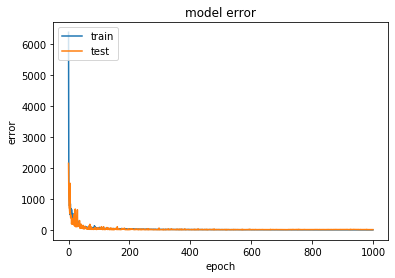

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
#print(error_prediction)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


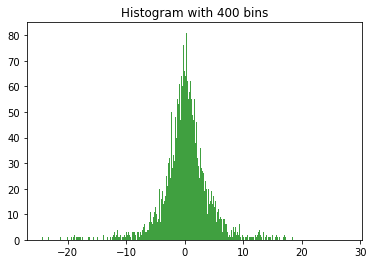

(400,)
(401,)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 400
    # variables        = 3
    chi-square         = 5201.68922
    reduced chi-square = 13.1024917
    Akaike info crit   = 1032.10966
    Bayesian info crit = 1044.08406
[[Variables]]
    amp:  61.5025376 +/- 0.78540428 (1.28%) (init = 1000)
    cen:  0.04007245 +/- 0.03445517 (85.98%) (init = 0)
    wid:  3.30463091 +/- 0.04872695 (1.47%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.577



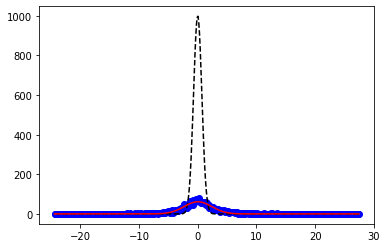

In [19]:

n, bins, patches = plt.hist(error_prediction, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()





In [20]:
FWHM=result.params['wid'].value*2*sqrt(log(2))

In [21]:
print(FWHM)

5.502571404570979


[[173.40935]
 [168.98141]
 [169.8466 ]
 [165.8452 ]
 [170.68944]
 [172.11304]
 [167.33737]
 [167.22536]
 [170.50864]
 [170.60715]
 [165.81616]
 [171.009  ]
 [166.85037]
 [168.78914]
 [170.21597]
 [170.25206]
 [175.57784]
 [172.65173]
 [170.59152]
 [167.96257]
 [167.39677]
 [167.35005]
 [167.13493]
 [170.56659]
 [168.82126]
 [169.49306]
 [172.0298 ]
 [165.00813]
 [170.03697]
 [166.18027]
 [173.14217]
 [168.47206]
 [164.946  ]
 [167.0731 ]
 [168.30527]
 [164.91293]
 [167.92369]
 [167.56534]
 [180.38303]
 [167.30089]
 [175.90779]
 [170.78679]
 [168.17902]
 [178.55606]
 [170.4883 ]
 [170.16376]
 [175.74742]
 [169.43875]
 [168.56404]
 [170.42577]
 [172.48155]
 [169.84718]
 [167.75835]
 [186.91115]
 [173.9883 ]
 [172.25264]
 [167.15681]
 [169.25151]
 [170.44203]
 [170.31143]
 [165.14867]
 [171.64061]
 [169.45964]
 [167.51775]
 [176.91165]
 [172.23311]
 [167.19986]
 [167.55342]
 [165.3728 ]
 [180.65909]
 [168.67766]
 [178.93964]
 [169.30322]
 [166.21257]
 [176.22356]
 [169.14708]
 [165.77315]

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


4.828078402771226


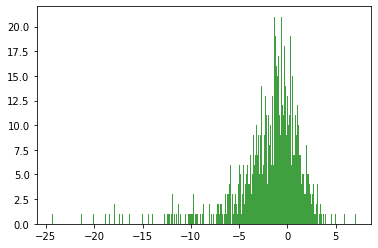

In [22]:
Y_test_bin0_predicted=model.predict(X_test_bin0)
print(Y_test_bin0_predicted)
error_prediction_bin0=Y_test_bin0-Y_test_bin0_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin0, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin0=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin0)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


5.218105083087939


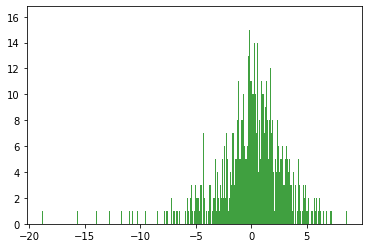

In [23]:
Y_test_bin1_predicted=model.predict(X_test_bin1)
#print(Y_test_bin1_predicted)
error_prediction_bin1=Y_test_bin1-Y_test_bin1_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin1, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin1=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin1)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


4.768666730502308


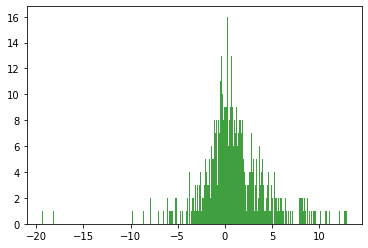

In [24]:
Y_test_bin2_predicted=model.predict(X_test_bin2)
#print(Y_test_bin2_predicted)
error_prediction_bin2=Y_test_bin2-Y_test_bin2_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin2, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin2=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin2)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


6.084813667384943


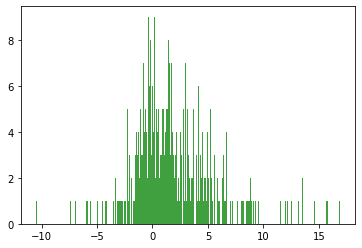

In [25]:
Y_test_bin3_predicted=model.predict(X_test_bin3)
#print(Y_test_bin3_predicted)
error_prediction_bin3=Y_test_bin3-Y_test_bin3_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin3, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin3=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin3)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


9.37534176923173
6.084813667384943
4.768666730502308
5.218105083087939
4.828078402771226


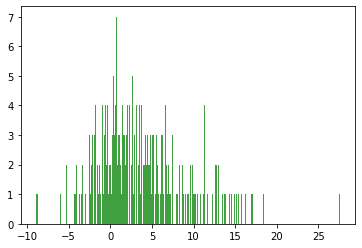

In [26]:
Y_test_bin4_predicted=model.predict(X_test_bin4)
#print(Y_test_bin4_predicted)
error_prediction_bin4=Y_test_bin4-Y_test_bin4_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin4, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin4=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin4)
print(FWHM_bin3)
print(FWHM_bin2)
print(FWHM_bin1)
print(FWHM_bin0)

Veamos ahora los histogramnas 2d que nos interesan